<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_comparison_solvers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=e73351b3d1cdac399254b50120ac7bf4488e9d7ccec21dfda016a93452b18754
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [2]:
pip install torchdyn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.5 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=0efb774cffadf396d45538c40a72b595d65c20166e8088a068461b90f2ff977d
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [3]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
import time
import random
# from torchdyn.numerics.solvers import SolverTemplate

In [4]:
# Make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Clone my repository to have access to code inside utilis
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 284 (delta 36), reused 18 (delta 6), pack-reused 203
Receiving objects: 100% (284/284), 7.39 MiB | 21.68 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [6]:
cd maestria

/content/maestria


In [7]:
ls

case_studies/   mc_fb/               ml_fb_optimization/    utilis/
data/           mc_fb_optimization/  parameter_estimation/
mc_batch/       ml_batch/            README.md
mc_continuous/  ml_fb/               tensors/


In [8]:
# Import functions from my utilis package
from utilis.functions import plot_trajectory, plot_predictions, create_time_span
from utilis.models import fnn_model, inhibition_model_nn
from utilis.solvers import DirectSolver, ResnetSolver

In [9]:
# Cargar el tensor desde el archivo
x0_train = torch.load('tensors/x0_train.pt')
x_train = torch.load('tensors/x_train.pt')
x0_validate = torch.load('tensors/x0_validate.pt')
x_validate = torch.load('tensors/x_validate.pt')

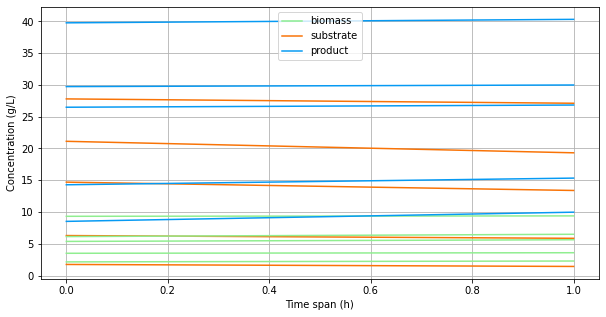

In [10]:
# Plot trajectory i from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

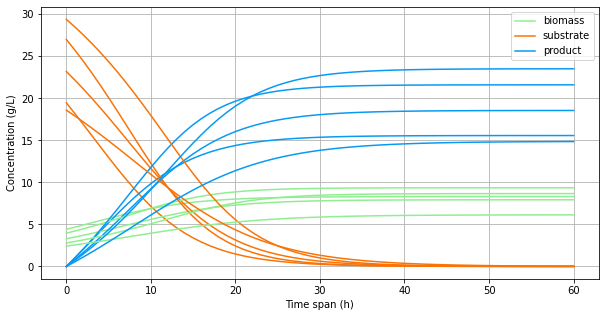

In [11]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

8. The optimization algorithm for training is Adam 

In [12]:
t_span_train = create_time_span(0, 1, 1)
t_span_validate = create_time_span(0,60,1)

# Direct solver 

In [109]:
# Create model
net_ds = fnn_model(3, 3, 32, 8)

In [110]:
# training algorithm
optimizer_ds = Adam(net_ds.parameters()) 

In [111]:
strat_time = time.time()
# training
losses_ds = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net_ds.train()

    # 1. Forward pass
    _, x_pred_train_ds = odeint(
        lambda t, x: net_ds(x),
        x0_train,
        t_span_train, 
        solver=DirectSolver()
    )

    # 2. Calculate loss
    loss_ds = mse_loss(x_pred_train_ds, x_train) 

    # 3. Zero grad
    optimizer_ds.zero_grad() 
    
    # 4. Backward pass
    loss_ds.backward()
    losses_ds.append(loss_ds.item())

    # 5. Update weights and biases
    optimizer_ds.step() 

    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss_ds}")
end_time = time.time()

  3%|▎         | 51/2000 [00:00<00:07, 254.63it/s]

Epoch: 0 | Training loss: 196.80493380740245
Epoch: 50 | Training loss: 25.147644661514697


  7%|▋         | 135/2000 [00:00<00:07, 261.06it/s]

Epoch: 100 | Training loss: 5.455148527547287
Epoch: 150 | Training loss: 0.4565177210948383


 13%|█▎        | 251/2000 [00:00<00:06, 274.17it/s]

Epoch: 200 | Training loss: 0.07318054707002565
Epoch: 250 | Training loss: 0.02134238656958787


 17%|█▋        | 335/2000 [00:01<00:06, 274.46it/s]

Epoch: 300 | Training loss: 0.011371030232486158
Epoch: 350 | Training loss: 0.007306909883115534


 23%|██▎       | 454/2000 [00:01<00:05, 288.46it/s]

Epoch: 400 | Training loss: 0.005211808783539702
Epoch: 450 | Training loss: 0.003881293313722493


 27%|██▋       | 542/2000 [00:01<00:05, 284.14it/s]

Epoch: 500 | Training loss: 0.003937446187313884
Epoch: 550 | Training loss: 0.003401555358767669


 32%|███▏      | 630/2000 [00:02<00:04, 288.20it/s]

Epoch: 600 | Training loss: 0.0019139537519397183
Epoch: 650 | Training loss: 0.0014576319128038345


 37%|███▋      | 745/2000 [00:02<00:04, 271.11it/s]

Epoch: 700 | Training loss: 0.0018346164663060258
Epoch: 750 | Training loss: 0.001134212360981051


 42%|████▏     | 835/2000 [00:03<00:04, 285.57it/s]

Epoch: 800 | Training loss: 0.0014681860238584161
Epoch: 850 | Training loss: 0.0009721678099317343


 48%|████▊     | 951/2000 [00:03<00:03, 283.05it/s]

Epoch: 900 | Training loss: 0.0009112207696053619
Epoch: 950 | Training loss: 0.0025213925074437887


 52%|█████▏    | 1036/2000 [00:03<00:03, 275.38it/s]

Epoch: 1000 | Training loss: 0.0008425827259025574
Epoch: 1050 | Training loss: 0.0009690953360565783


 57%|█████▊    | 1150/2000 [00:04<00:03, 278.83it/s]

Epoch: 1100 | Training loss: 0.0008076253850912974
Epoch: 1150 | Training loss: 0.004717324055869855


 62%|██████▏   | 1234/2000 [00:04<00:02, 271.45it/s]

Epoch: 1200 | Training loss: 0.000735830979733883
Epoch: 1250 | Training loss: 0.013811769464851015


 67%|██████▋   | 1349/2000 [00:04<00:02, 279.23it/s]

Epoch: 1300 | Training loss: 0.0007070975209684367
Epoch: 1350 | Training loss: 0.0006815707262151046


 72%|███████▏  | 1436/2000 [00:05<00:02, 280.62it/s]

Epoch: 1400 | Training loss: 0.0008476288981587622
Epoch: 1450 | Training loss: 0.00478889547740719


 78%|███████▊  | 1550/2000 [00:05<00:01, 272.31it/s]

Epoch: 1500 | Training loss: 0.0007348738213788466
Epoch: 1550 | Training loss: 0.0006233473504331457


 82%|████████▏ | 1636/2000 [00:05<00:01, 275.26it/s]

Epoch: 1600 | Training loss: 0.0006077712522996822
Epoch: 1650 | Training loss: 0.0006838100578162425


 88%|████████▊ | 1750/2000 [00:06<00:00, 270.96it/s]

Epoch: 1700 | Training loss: 0.0006076885952464014
Epoch: 1750 | Training loss: 0.0016082241617857759


 91%|█████████▏| 1829/2000 [00:06<00:00, 241.33it/s]

Epoch: 1800 | Training loss: 0.0005809529381282893
Epoch: 1850 | Training loss: 0.000563219443954413


 97%|█████████▋| 1944/2000 [00:07<00:00, 274.76it/s]

Epoch: 1900 | Training loss: 0.003185457725775838
Epoch: 1950 | Training loss: 0.0005750745663915846


100%|██████████| 2000/2000 [00:07<00:00, 273.47it/s]


In [112]:
total_time_ds = end_time - strat_time 
print(f"Total time: {total_time_ds:.3f}s")

Total time: 7.321s


In [113]:
# Make predictions 
net_ds.eval()
with torch.inference_mode():
    _, x_pred_validate_ds = odeint(lambda t, x: net_ds(
        x), x0_validate, t_span_validate, solver=DirectSolver()
    ) 

In [114]:
print(x_pred_validate_ds.shape)

torch.Size([61, 10, 3])


In [115]:
loss_validate_ds = mse_loss(x_pred_validate_ds, x_validate)
print(loss_validate_ds)

tensor(45.1284, dtype=torch.float64)


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

Validation 0


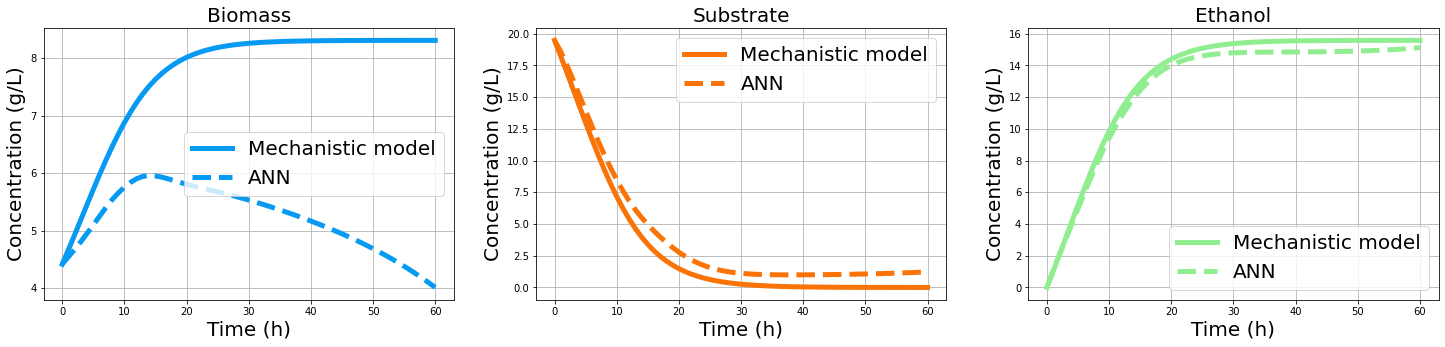

Validation 1


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

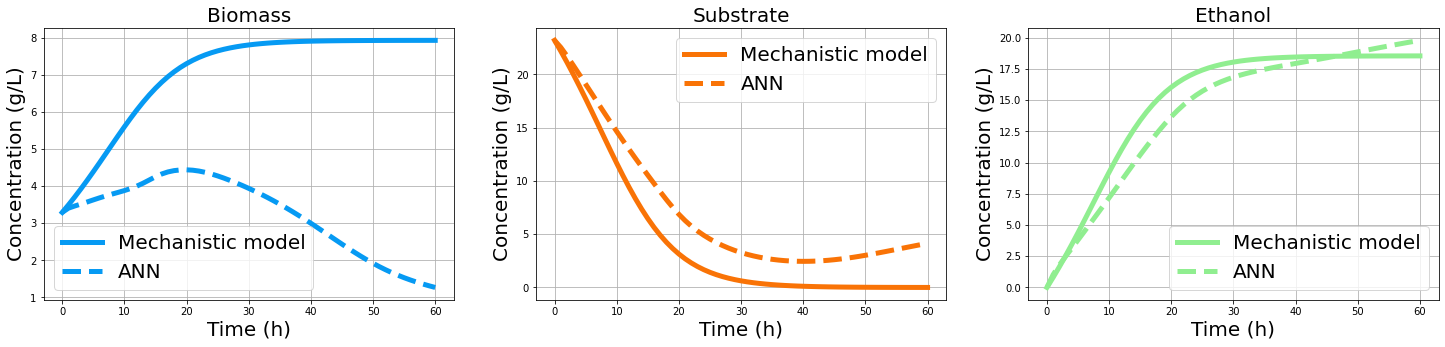

Validation 2


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

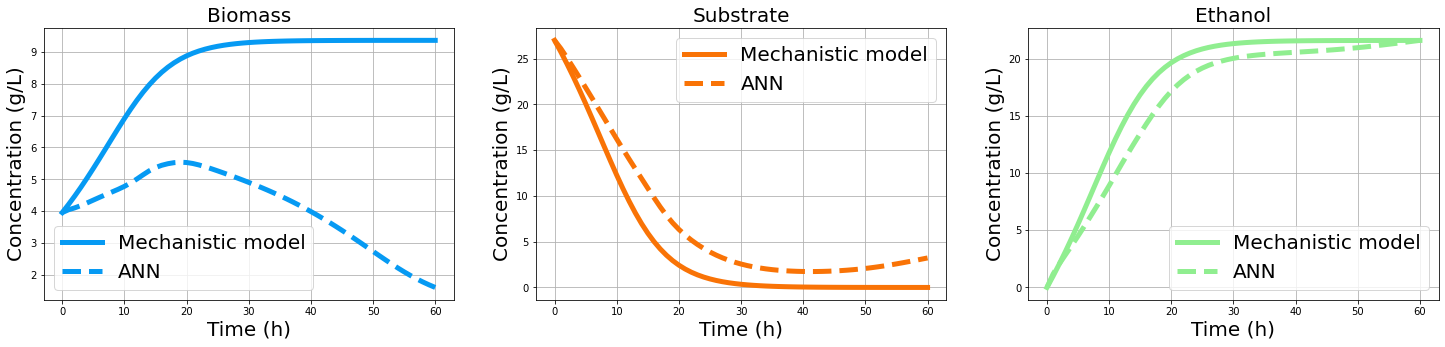

Validation 3


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

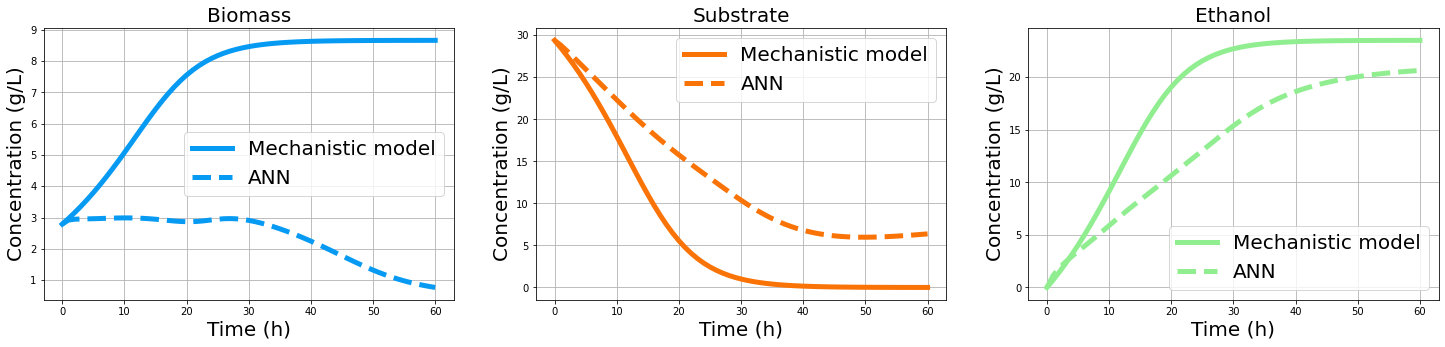

Validation 4


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

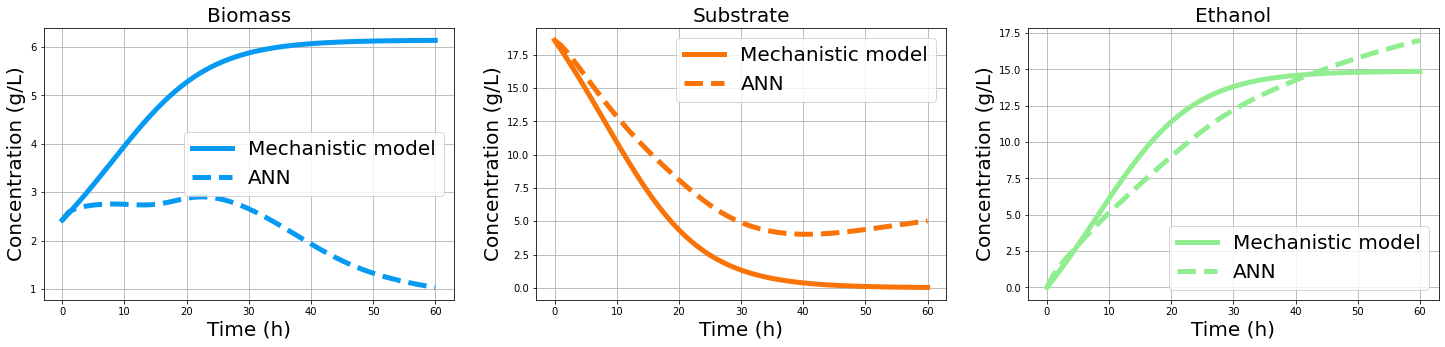

In [116]:
for i in range(5):
    plot_predictions(t_span_validate, x_validate, x_pred_validate_ds, i)

# Resnet Solver

In [117]:
# Create model
net_rs = fnn_model(3, 3, 32, 8)

In [118]:
# training algorithm
optimizer_rs = Adam(net_rs.parameters()) 

In [119]:
strat_time = time.time()
# training
losses_rs = []


epochs = 2000

for epoch in tqdm(range(epochs)): 

    net_rs.train()

    # 1. Forward pass
    _, x_pred_train_rs = odeint(
        lambda t, x: net_rs(x),
        x0_train,
        t_span_train, 
        solver=ResnetSolver()
    )

    # 2. Calculate loss
    loss_rs = mse_loss(x_pred_train_rs, x_train) 

    # 3. Zero grad
    optimizer_rs.zero_grad() 
    
    # 4. Backward pass
    loss_rs.backward()
    losses_rs.append(loss_rs.item())

    # 5. Update weights and biases
    optimizer_rs.step() 

    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss_rs}")
end_time = time.time()

  3%|▎         | 56/2000 [00:00<00:07, 268.24it/s]

Epoch: 0 | Training loss: 0.9684492679195487
Epoch: 50 | Training loss: 0.02036342086871804


  7%|▋         | 141/2000 [00:00<00:07, 262.83it/s]

Epoch: 100 | Training loss: 0.0016015378803601252
Epoch: 150 | Training loss: 0.0005256943512406739


 13%|█▎        | 253/2000 [00:00<00:06, 271.10it/s]

Epoch: 200 | Training loss: 0.0003438305680061129
Epoch: 250 | Training loss: 0.0002570411443565226


 17%|█▋        | 340/2000 [00:01<00:05, 276.76it/s]

Epoch: 300 | Training loss: 0.00020809927789211964
Epoch: 350 | Training loss: 0.0001862744328764018


 23%|██▎       | 452/2000 [00:01<00:05, 271.01it/s]

Epoch: 400 | Training loss: 0.0002785440986795215
Epoch: 450 | Training loss: 0.00013242142722549651


 27%|██▋       | 536/2000 [00:01<00:05, 271.73it/s]

Epoch: 500 | Training loss: 0.00025068710625304915
Epoch: 550 | Training loss: 0.00010287396963182872


 32%|███▏      | 646/2000 [00:02<00:05, 262.42it/s]

Epoch: 600 | Training loss: 0.0004754679785124749
Epoch: 650 | Training loss: 9.014721021936115e-05


 36%|███▋      | 727/2000 [00:02<00:04, 260.97it/s]

Epoch: 700 | Training loss: 7.607717622042249e-05
Epoch: 750 | Training loss: 6.851485094521132e-05


 42%|████▏     | 835/2000 [00:03<00:04, 260.73it/s]

Epoch: 800 | Training loss: 6.179879377349135e-05
Epoch: 850 | Training loss: 0.00013909935441432382


 48%|████▊     | 951/2000 [00:03<00:03, 278.73it/s]

Epoch: 900 | Training loss: 5.401871863903869e-05
Epoch: 950 | Training loss: 4.877669303851338e-05


 52%|█████▏    | 1036/2000 [00:03<00:03, 270.80it/s]

Epoch: 1000 | Training loss: 4.436196107691204e-05
Epoch: 1050 | Training loss: 4.029736271923561e-05


 57%|█████▋    | 1146/2000 [00:04<00:03, 269.08it/s]

Epoch: 1100 | Training loss: 0.00189867467334771
Epoch: 1150 | Training loss: 3.667833375747648e-05


 63%|██████▎   | 1258/2000 [00:04<00:02, 275.46it/s]

Epoch: 1200 | Training loss: 3.252048410421402e-05
Epoch: 1250 | Training loss: 2.9384861445897534e-05


 67%|██████▋   | 1343/2000 [00:05<00:02, 277.27it/s]

Epoch: 1300 | Training loss: 2.6740614281304437e-05
Epoch: 1350 | Training loss: 2.4382189858878054e-05


 71%|███████▏  | 1429/2000 [00:05<00:02, 275.56it/s]

Epoch: 1400 | Training loss: 0.002077000448061759
Epoch: 1450 | Training loss: 2.4552415347307097e-05


 77%|███████▋  | 1543/2000 [00:05<00:01, 277.49it/s]

Epoch: 1500 | Training loss: 2.147144771702243e-05
Epoch: 1550 | Training loss: 1.960234347533133e-05


 81%|████████▏ | 1629/2000 [00:06<00:01, 275.89it/s]

Epoch: 1600 | Training loss: 1.8021977622838395e-05
Epoch: 1650 | Training loss: 1.663530529767093e-05


 87%|████████▋ | 1747/2000 [00:06<00:00, 260.13it/s]

Epoch: 1700 | Training loss: 1.540337560933257e-05


 90%|█████████ | 1804/2000 [00:06<00:00, 268.77it/s]

Epoch: 1750 | Training loss: 0.00032228305826673977
Epoch: 1800 | Training loss: 2.0301590550413635e-05


 94%|█████████▍| 1890/2000 [00:07<00:00, 278.94it/s]

Epoch: 1850 | Training loss: 1.4877853638425844e-05
Epoch: 1900 | Training loss: 1.368311030564219e-05


100%|██████████| 2000/2000 [00:07<00:00, 268.51it/s]

Epoch: 1950 | Training loss: 1.2729468011210284e-05


In [120]:
total_time_rs = end_time - strat_time 
print(f"Total time: {total_time_rs:.3f}s")

Total time: 7.454s


In [121]:
# Make predictions 
net_rs.eval()
with torch.inference_mode():
    _, x_pred_validate_rs = odeint(lambda t, x: net_rs(
        x), x0_validate, t_span_validate, solver=ResnetSolver()
    ) 

In [122]:
print(x_pred_validate_rs.shape)

torch.Size([61, 10, 3])


In [123]:
loss_validate_rs = mse_loss(x_pred_validate_rs, x_validate)
print(loss_validate_rs)

tensor(0.0177, dtype=torch.float64)


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

Validation 0


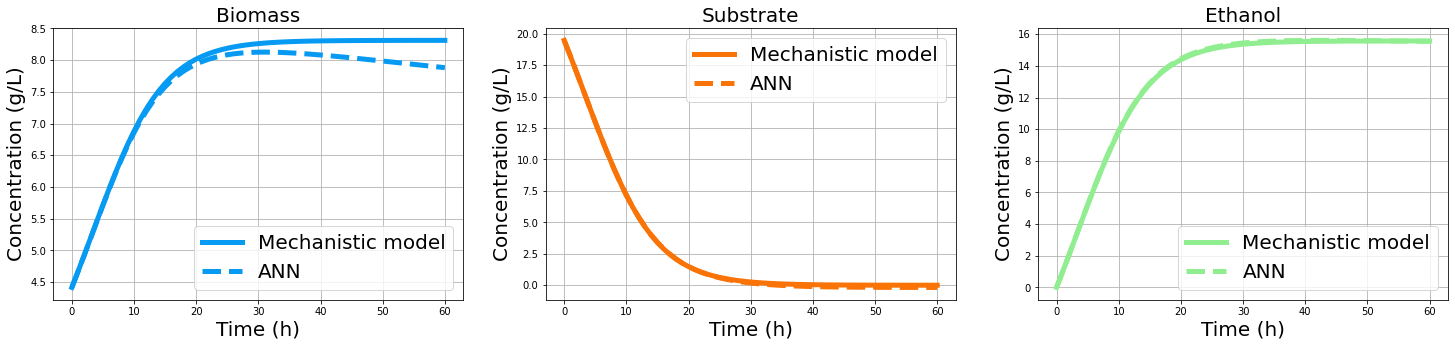

Validation 1


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

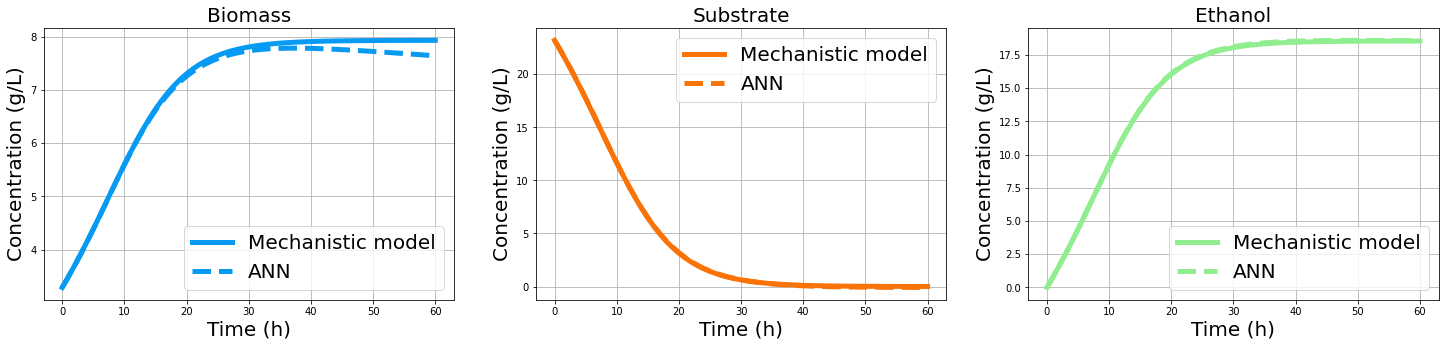

Validation 2


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

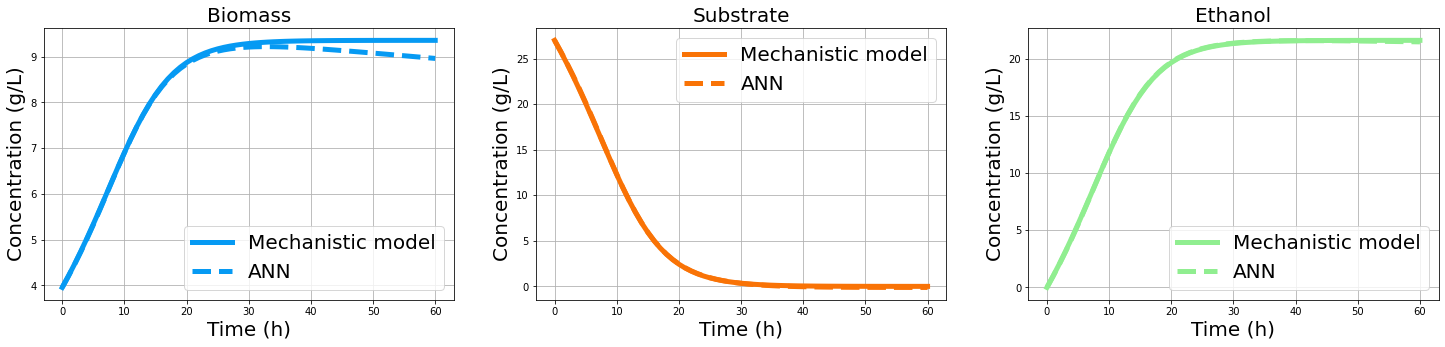

Validation 3


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

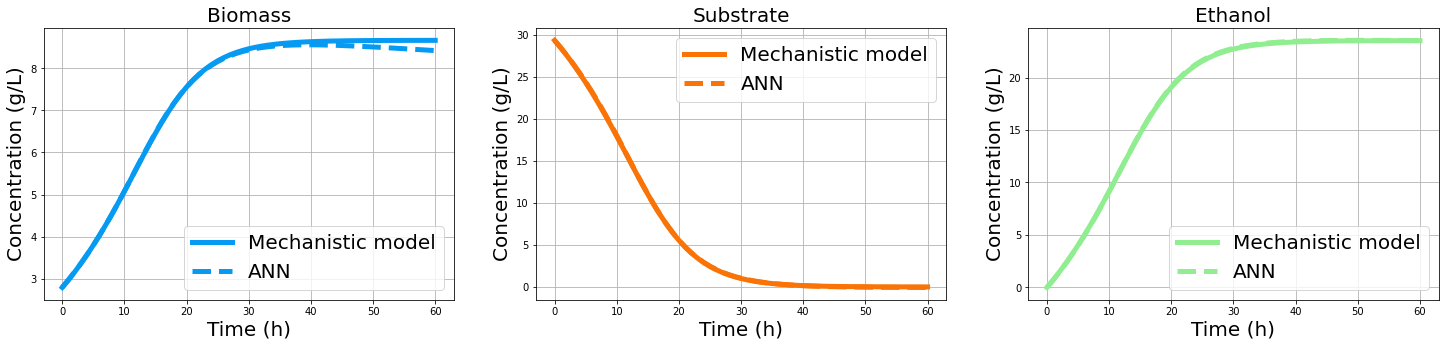

Validation 4


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

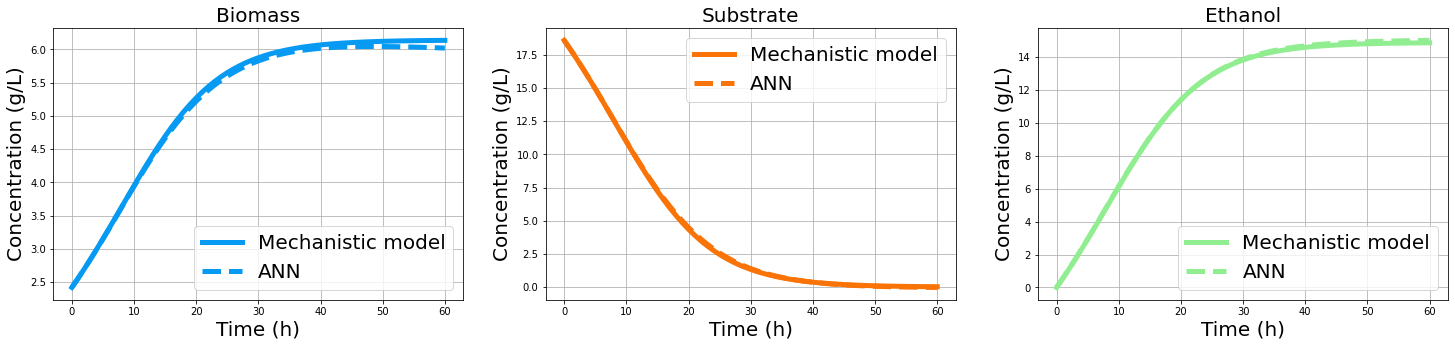

In [124]:
for i in range(5):
    plot_predictions(t_span_validate, x_validate, x_pred_validate_rs, i)

# Numeric solver

In [125]:
# Create model
net_ns = fnn_model(3, 3, 32, 8)

In [126]:
# training algorithm
optimizer_ns = Adam(net_ns.parameters()) 

In [127]:
strat_time = time.time()
# training
losses_ns = []


epochs = 2000

for epoch in tqdm(range(epochs)): 

    net_ns.train()

    # 1. Forward pass
    _, x_pred_train_ns = odeint(
        lambda t, x: net_ns(x),
        x0_train,
        t_span_train, 
        solver="rk4"
    )

    # 2. Calculate loss
    loss_ns = mse_loss(x_pred_train_ns, x_train) 

    # 3. Zero grad
    optimizer_ns.zero_grad() 
    
    # 4. Backward pass
    loss_ns.backward()
    losses_ns.append(loss_ns.item())

    # 5. Update weights and biases
    optimizer_ns.step() 

    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss_ns}")
end_time = time.time()

  1%|          | 12/2000 [00:00<00:17, 111.73it/s]

Epoch: 0 | Training loss: 0.6503885788558703


  4%|▎         | 70/2000 [00:00<00:17, 109.15it/s]

Epoch: 50 | Training loss: 0.013903161128664132


  6%|▌         | 117/2000 [00:01<00:16, 112.07it/s]

Epoch: 100 | Training loss: 0.0020770208139912574


  8%|▊         | 166/2000 [00:01<00:16, 113.39it/s]

Epoch: 150 | Training loss: 0.0007737529491567471


 11%|█         | 214/2000 [00:01<00:15, 115.81it/s]

Epoch: 200 | Training loss: 0.0004310590193531838


 13%|█▎        | 263/2000 [00:02<00:15, 114.75it/s]

Epoch: 250 | Training loss: 0.0003210228402767484


 16%|█▌        | 323/2000 [00:02<00:14, 112.32it/s]

Epoch: 300 | Training loss: 0.0002687904705708217


 19%|█▊        | 371/2000 [00:03<00:14, 111.72it/s]

Epoch: 350 | Training loss: 0.00023529539932264134


 21%|██        | 418/2000 [00:03<00:14, 111.08it/s]

Epoch: 400 | Training loss: 0.00023322759957281855


 23%|██▎       | 466/2000 [00:04<00:14, 109.37it/s]

Epoch: 450 | Training loss: 0.00018211894258115152


 26%|██▌       | 513/2000 [00:04<00:13, 110.25it/s]

Epoch: 500 | Training loss: 0.0001755739595703373


 29%|██▊       | 574/2000 [00:05<00:12, 112.52it/s]

Epoch: 550 | Training loss: 0.00014480654959933426


 31%|███       | 622/2000 [00:05<00:12, 112.36it/s]

Epoch: 600 | Training loss: 0.00012710018782747872


 34%|███▎      | 670/2000 [00:06<00:11, 111.93it/s]

Epoch: 650 | Training loss: 0.00018034982510524927


 36%|███▌      | 719/2000 [00:06<00:11, 112.33it/s]

Epoch: 700 | Training loss: 0.00010437117220401184


 38%|███▊      | 766/2000 [00:06<00:11, 107.23it/s]

Epoch: 750 | Training loss: 9.049367454534646e-05


 41%|████      | 813/2000 [00:07<00:10, 112.46it/s]

Epoch: 800 | Training loss: 9.196818276389034e-05


 44%|████▎     | 873/2000 [00:07<00:10, 112.39it/s]

Epoch: 850 | Training loss: 8.249102163772913e-05


 46%|████▌     | 922/2000 [00:08<00:09, 116.00it/s]

Epoch: 900 | Training loss: 6.707168240148338e-05


 48%|████▊     | 969/2000 [00:08<00:09, 108.21it/s]

Epoch: 950 | Training loss: 5.977415628575099e-05


 51%|█████     | 1017/2000 [00:09<00:08, 112.05it/s]

Epoch: 1000 | Training loss: 5.342743258735503e-05


 53%|█████▎    | 1066/2000 [00:09<00:08, 114.85it/s]

Epoch: 1050 | Training loss: 0.00010552399490835725


 56%|█████▌    | 1114/2000 [00:10<00:07, 112.99it/s]

Epoch: 1100 | Training loss: 4.821821063092069e-05


 58%|█████▊    | 1162/2000 [00:10<00:07, 112.82it/s]

Epoch: 1150 | Training loss: 4.349426906082978e-05


 61%|██████    | 1222/2000 [00:10<00:06, 112.93it/s]

Epoch: 1200 | Training loss: 3.93316044606013e-05


 64%|██████▎   | 1270/2000 [00:11<00:06, 114.60it/s]

Epoch: 1250 | Training loss: 3.5731014198436955e-05


 66%|██████▌   | 1317/2000 [00:11<00:06, 108.61it/s]

Epoch: 1300 | Training loss: 3.279970544828218e-05


 68%|██████▊   | 1365/2000 [00:12<00:05, 115.31it/s]

Epoch: 1350 | Training loss: 3.7646027437067766e-05


 71%|███████   | 1413/2000 [00:12<00:05, 113.11it/s]

Epoch: 1400 | Training loss: 3.2287281112009096e-05


 74%|███████▎  | 1474/2000 [00:13<00:04, 112.98it/s]

Epoch: 1450 | Training loss: 2.955375034111078e-05


 76%|███████▌  | 1523/2000 [00:13<00:04, 112.59it/s]

Epoch: 1500 | Training loss: 2.7564120406492816e-05


 79%|███████▊  | 1572/2000 [00:14<00:03, 113.89it/s]

Epoch: 1550 | Training loss: 2.5805780742054426e-05


 81%|████████  | 1621/2000 [00:14<00:03, 116.87it/s]

Epoch: 1600 | Training loss: 2.421349789428694e-05


 83%|████████▎ | 1669/2000 [00:14<00:02, 113.26it/s]

Epoch: 1650 | Training loss: 3.159487743545273e-05


 86%|████████▌ | 1717/2000 [00:15<00:02, 115.42it/s]

Epoch: 1700 | Training loss: 3.330631303785459e-05


 88%|████████▊ | 1765/2000 [00:15<00:02, 114.55it/s]

Epoch: 1750 | Training loss: 2.3666694735900627e-05


 91%|█████████▏| 1825/2000 [00:16<00:01, 114.43it/s]

Epoch: 1800 | Training loss: 2.193242156785891e-05


 94%|█████████▎| 1873/2000 [00:16<00:01, 109.87it/s]

Epoch: 1850 | Training loss: 2.059379512044114e-05


 96%|█████████▌| 1921/2000 [00:17<00:00, 111.81it/s]

Epoch: 1900 | Training loss: 1.9384383835085697e-05


 98%|█████████▊| 1968/2000 [00:17<00:00, 106.95it/s]

Epoch: 1950 | Training loss: 1.8265844907117823e-05


100%|██████████| 2000/2000 [00:17<00:00, 111.40it/s]


In [128]:
total_time_ns = end_time - strat_time 
print(f"Total time: {total_time_ns:.3f}s")

Total time: 17.960s


In [129]:
# Make predictions 
net_ns.eval()
with torch.inference_mode():
    _, x_pred_validate_ns = odeint(lambda t, x: net_ns(
        x), x0_validate, t_span_validate, solver="rk4"
    ) 

In [130]:
print(x_pred_validate_ns.shape)

torch.Size([61, 10, 3])


In [131]:
loss_validate_ns = mse_loss(x_pred_validate_ns, x_validate)
print(loss_validate_ns)

tensor(0.0246, dtype=torch.float64)


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

Validation 0


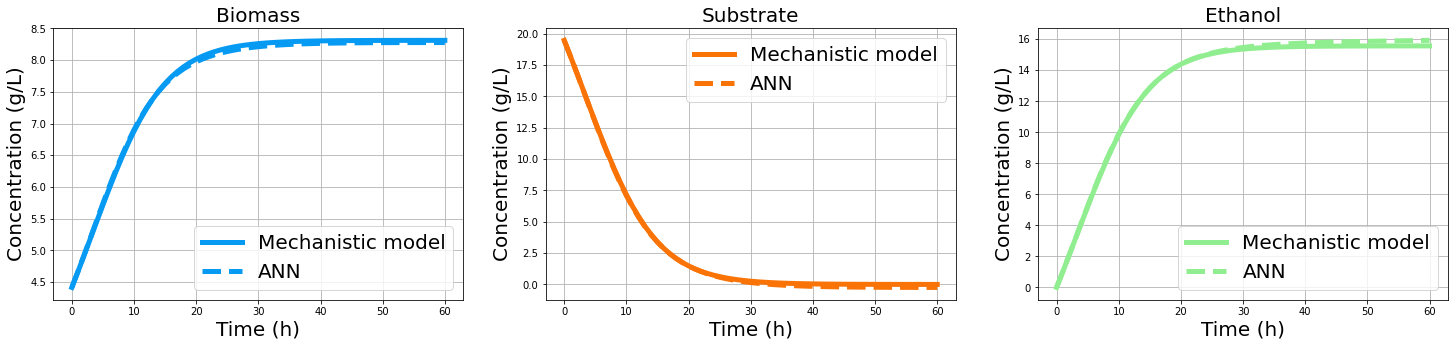

Validation 1


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

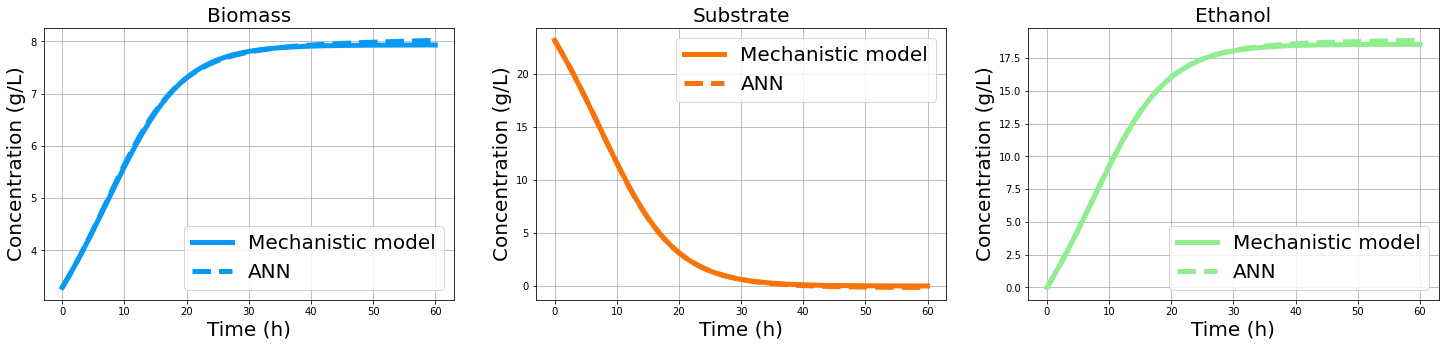

Validation 2


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

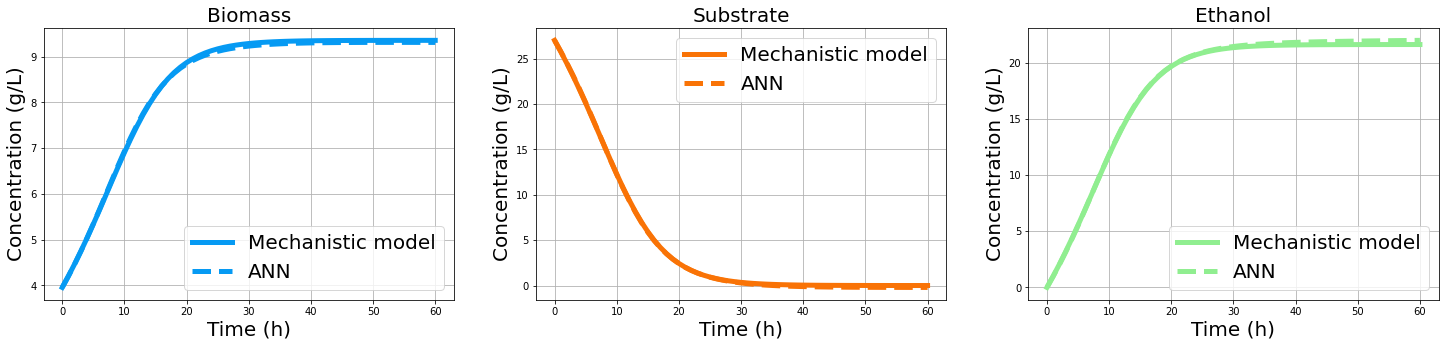

Validation 3


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

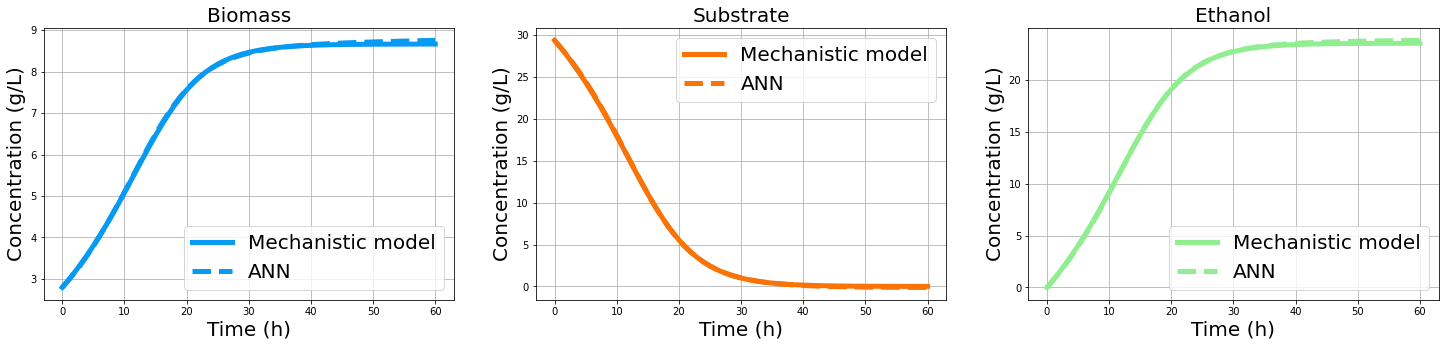

Validation 4


/content/maestria/utilis/functions.py:262: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:275: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:288: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

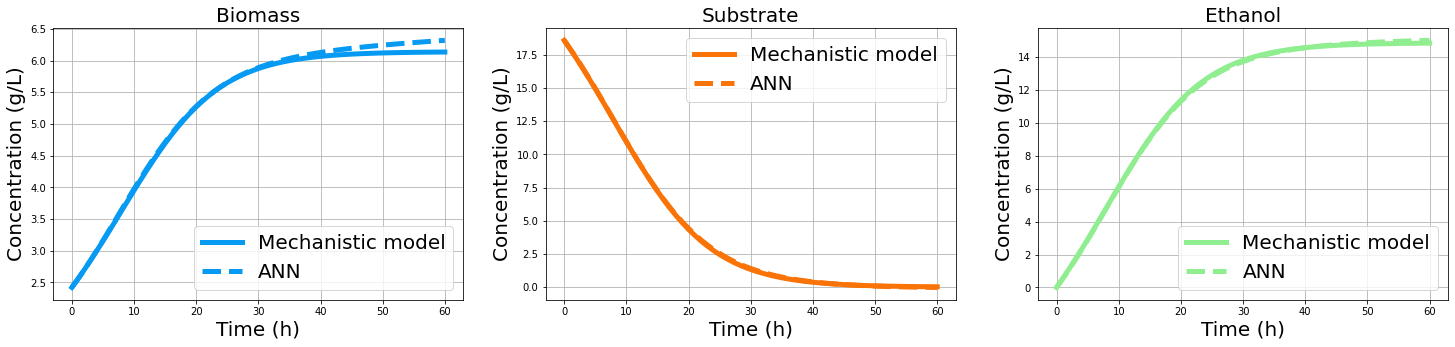

In [132]:
for i in range(5):
    plot_predictions(t_span_validate, x_validate, x_pred_validate_ns, i)

# Comparison

What minimum training loss value was achieved with each configuration?

In [133]:
print(f"Minimum training loss with direct solver: {loss_ds.item():.10f}")
print(f"Minimum training loss with resnet solver: {loss_rs.item():.10f}")
print(f"Minimum training loss with numeric solver: {loss_ns.item():.10f}")

Minimum training loss with direct solver: 0.0417475475
Minimum training loss with resnet solver: 0.0000119331
Minimum training loss with numeric solver: 0.0000172413


What minimum validation loss was achieved with each configuration?

In [134]:
print(f"Minimum validation loss with direct solver: {loss_validate_ds.item():.10f}")
print(f"Minimum validation loss with resnet solver: {loss_validate_rs.item():.10f}")
print(f"Minimum validation loss with numeric solver: {loss_validate_ns.item():.10f}")

Minimum validation loss with direct solver: 45.1284475991
Minimum validation loss with resnet solver: 0.0176771470
Minimum validation loss with numeric solver: 0.0246493585


In [135]:
print(f"Training time with direct solver: {total_time_ds:.3f}s")
print(f"Training time with resnet solver: {total_time_rs:.3f}s")
print(f"Training time with numeric solver: {total_time_ns:.3f}s")

Training time with direct solver: 7.321s
Training time with resnet solver: 7.454s
Training time with numeric solver: 17.960s


Training time with direct solver: 7.097s, 7.311s, 7.321s


Training time with resnet solver: 7.219s, 9.380s, 7.454s


Training time with numeric solver: 18.089s, 19.105s, 17.960s


In [136]:
def plot_loss():
    plt.figure(figsize = (10 ,5))
    plt.plot(losses_ds, label = 'Direct solver', lw = 3)
    plt.plot(losses_rs, label = 'Resnet solver', lw = 3)
    plt.plot(losses_ns, label = 'Numeric solver', lw = 3)
    plt.xlabel('Epochs', size = 20)
    plt.ylabel("Loss value", size = 20)
    plt.yscale('log')
    plt.grid()
    plt.legend()
    plt.show()

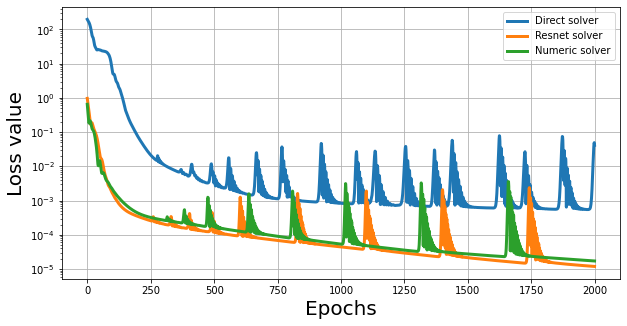

In [137]:
plot_loss()

In [138]:
#@title compare solvers
def compare_predictions(t_span, x,
                        x_pred_ds,
                        x_pred_rs,
                        x_pred_ns, 
                        n=0):

    print("Validation", n)

    # Create figure
    plt.figure(figsize = (25,5))

    # plot biomass
    plt.subplot(131)
    plt.scatter(
        t_span, 
        x[:, n, 0], 
        c="k", label = 'Mechanistic model', s = 20)

    # plot substrate
    plt.subplot(132)
    plt.scatter(
        t_span, 
        x[:, n, 1], 
        c="k", label = 'Mechanistic model', s = 20)

    # plot ethanol
    plt.subplot(133)
    plt.scatter(
        t_span, 
        x[:, n, 2], 
        c="k", label = 'Mechanistic model', s = 20)


    # plot biomass
    plt.subplot(131)
    plt.plot(
        t_span,
        x_pred_ds[:, n, 0], label = 'Direct solver', linestyle="solid",
        linewidth = 5)
    
    plt.plot(
        t_span,
        x_pred_rs[:, n, 0], label = 'Resnet solver', linestyle="dashed",
        linewidth = 5)

    plt.plot(
        t_span,
        x_pred_ns[:, n, 0], label = 'Numeric solver', linestyle="dashdot",
        linewidth = 5)
    
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Biomass", size = 20)
    plt.legend(fontsize = 10)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span,
        x_pred_ds[:, n, 1], label = 'Direct solver', linestyle="solid",
        linewidth = 5)
    
    plt.plot(
        t_span,
        x_pred_rs[:, n, 1], label = 'Resnet solver',  linestyle="dashed",
        linewidth = 5)

    plt.plot(
        t_span,
        x_pred_ns[:, n, 1], label = 'Numeric solver', linestyle="dashdot",
        linewidth = 5)

    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Substrate", size = 20)
    plt.legend(fontsize = 10)

    # plot ethanol
    plt.subplot(133)
    plt.plot(
        t_span,
        x_pred_ds[:, n, 2], label = 'Direct solver',  linestyle="solid",
        linewidth = 5)
    
    plt.plot(
        t_span,
        x_pred_rs[:, n, 2], label = 'Resnet solver', linestyle="dashed",
        linewidth = 5)

    plt.plot(
        t_span,
        x_pred_ns[:, n, 2], label = 'Numeric solver', linestyle="dashdot",
        linewidth = 5)
    
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Product", size = 20)
    plt.legend(fontsize = 10)

    plt.show()

Validation 0


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

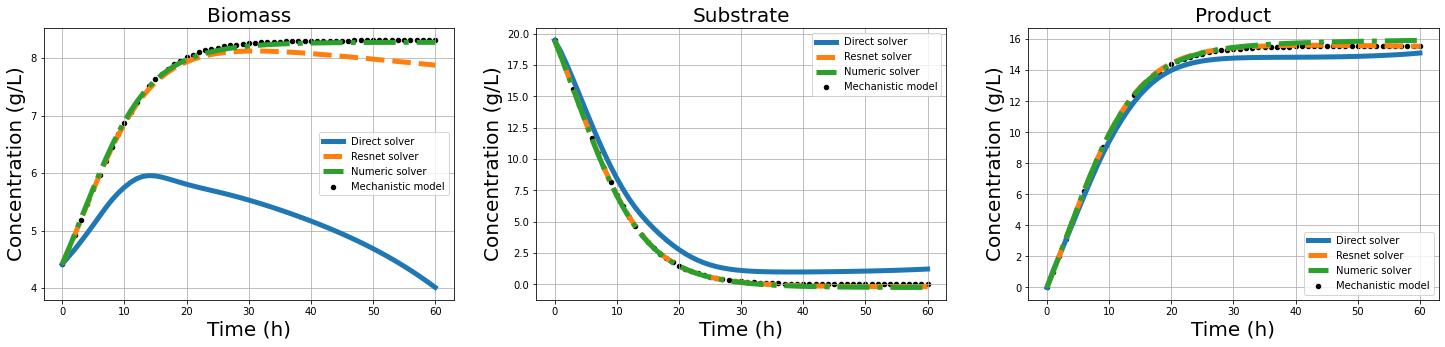

Validation 1


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

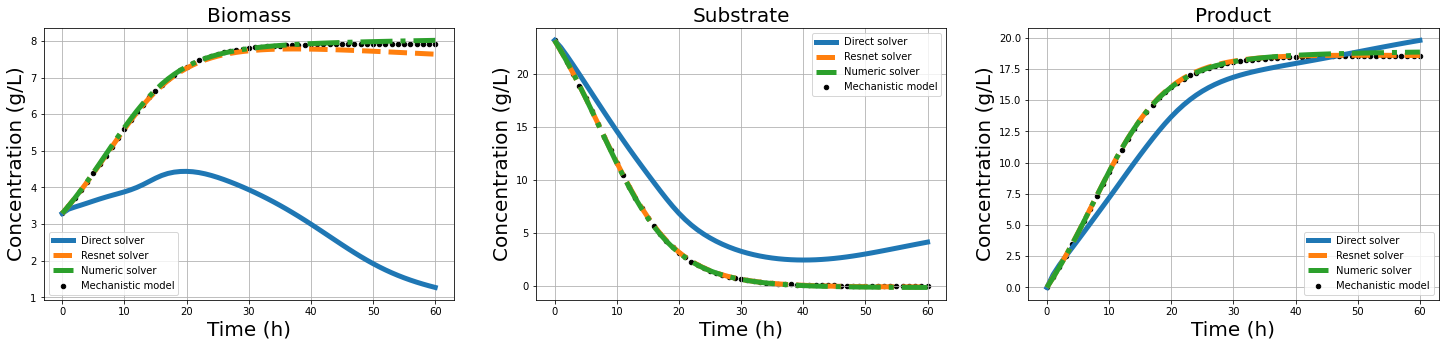

Validation 2


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

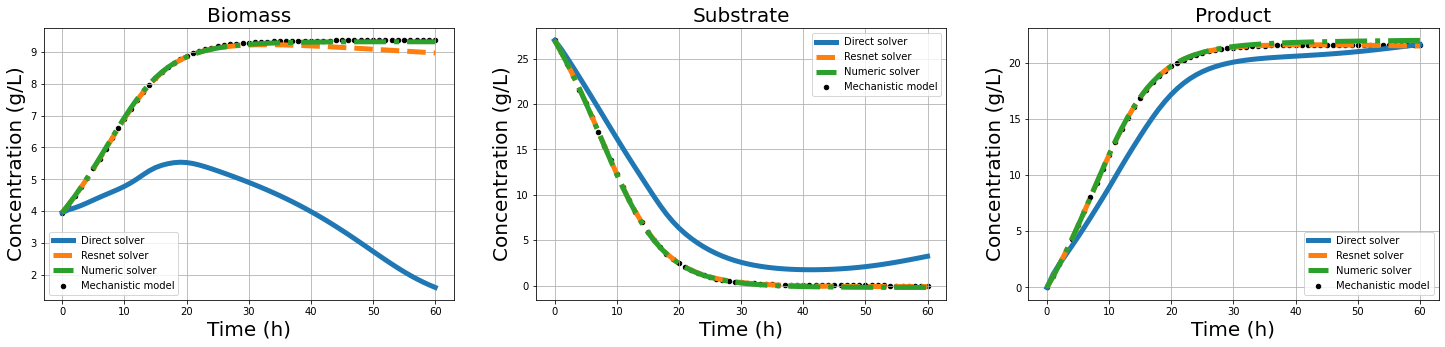

Validation 3


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

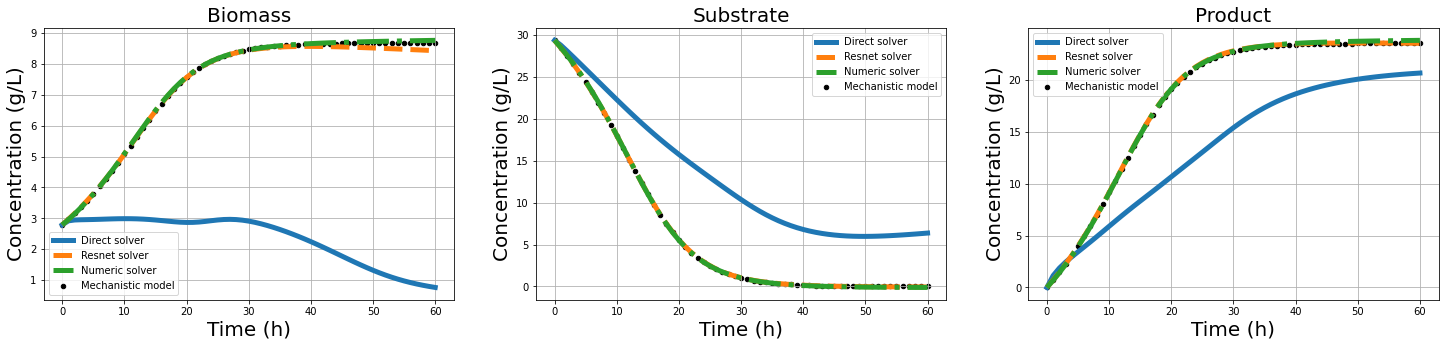

Validation 4


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

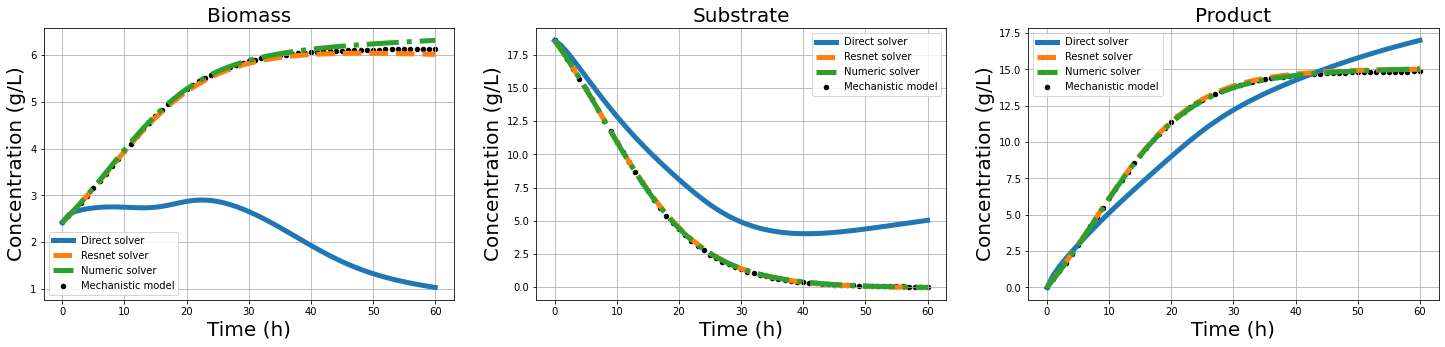

Validation 5


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

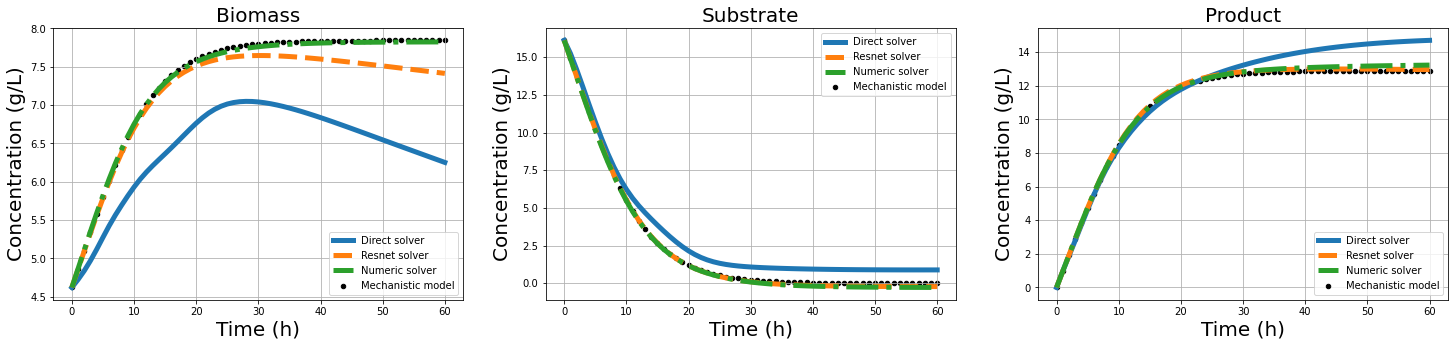

Validation 6


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

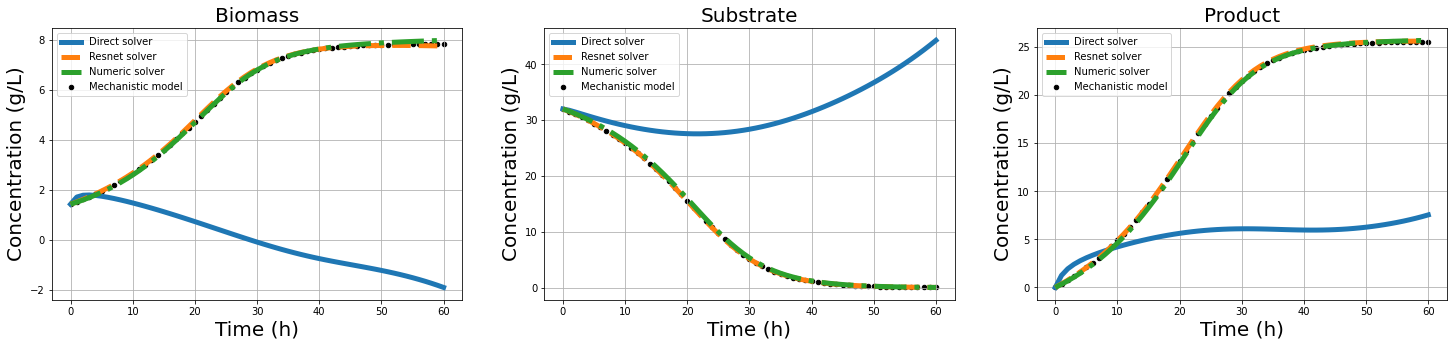

Validation 7


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

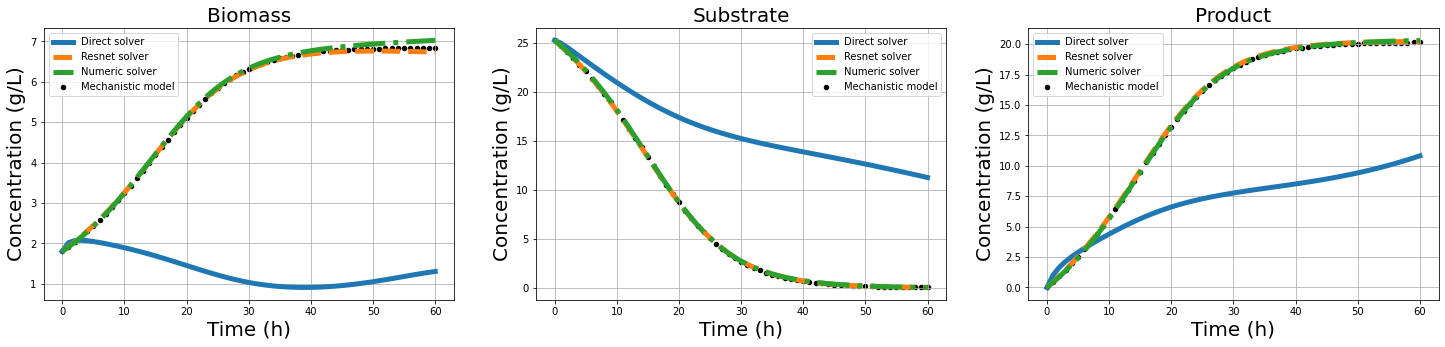

Validation 8


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

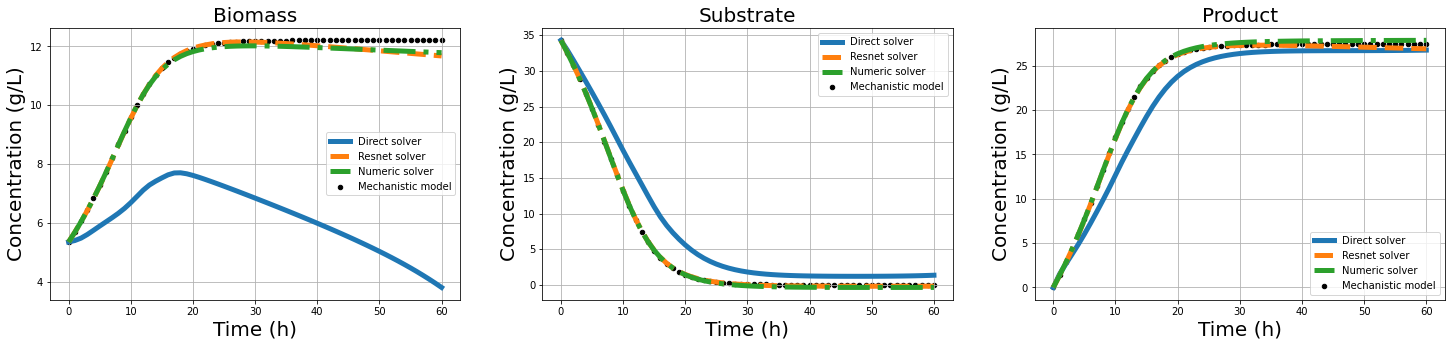

Validation 9


<ipython-input-138-ac0ef1d4b881>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-138-ac0ef1d4b881>:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-138-ac0ef1d4b881>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

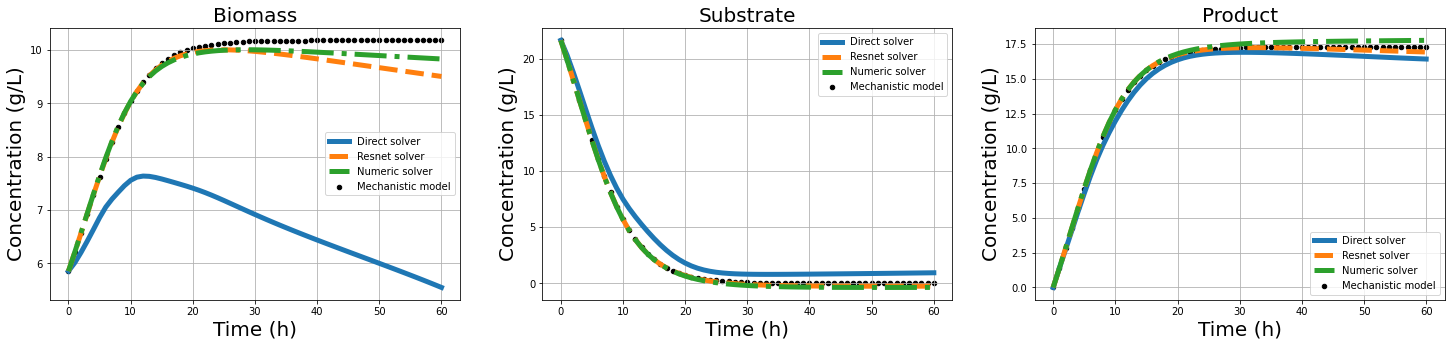

In [139]:
for i in range(10):
    compare_predictions(t_span_validate, 
                    x_validate,
                    x_pred_validate_ds, 
                    x_pred_validate_rs,
                    x_pred_validate_ns,
                    i)